In [1]:
import tensorflow as tf
import os
import sys
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix as cf
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Dropout, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as v2
from keras.applications.densenet import DenseNet201
from keras.applications.densenet import preprocess_input as dn
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xc

## Checking to see if gpu is available and enable memory growth on it to allocate only as much GPU memory as needed

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("num GPUs available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

num GPUs available:  1


In [3]:
keras.backend.clear_session()

# Get images from where they are located, initializing the image size and shape as well as the batch size.

In [4]:
images_path = 'archive/images/Images'

input_shape = (224, 224, 3)
image_size = (224, 224)
batch_size = 16

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    images_path, 
    label_mode = 'categorical',
    color_mode = 'rgb', 
    batch_size = batch_size, 
    image_size = image_size,
    shuffle = True, 
    validation_split = 0.2, 
    subset = 'training',
    seed = 100,
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    images_path, 
    label_mode = 'categorical',
    color_mode = 'rgb', 
    batch_size = batch_size, 
    image_size = image_size,
    shuffle = True, 
    validation_split = 0.2, 
    subset = 'validation',
    seed = 100,
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


# Split validation into test and validation, get the label names, and cache/prefetch the data

In [5]:
val_batches = tf.data.experimental.cardinality(ds_val)
test_dataset = ds_val.take(val_batches // 5)
ds_val = ds_val.skip(val_batches // 5)

labels = ds_train.class_names

AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size = AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size = AUTOTUNE)

# Define early stopping cariteria and data augmentation

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'auto')

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Download the base model and freeze the weights for feature extraction.

In [7]:
base_model = MobileNetV2(weights = "imagenet", include_top = False, pooling = 'avg', input_shape = input_shape, alpha = 1.4)
base_model.summary()

Model: "mobilenetv2_1.40_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 48) 192         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 48) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [8]:
base_model.trainable = False

# Build a functional keras model and define the loss and optimizer

In [9]:
inputs = tf.keras.Input(shape = input_shape)
x = data_augmentation(inputs)
x = xc(inputs)
x = base_model(x, training = False)
dropout = Dropout(0.2)(x)
output = Dense(120, activation = "softmax")(dropout)
model = Model(inputs = inputs, outputs = output)

In [10]:
optimizer = keras.optimizers.Nadam(learning_rate = 1e-4)
loss = keras.losses.CategoricalCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Train model for 50 epochs or until early stopping criteria is met

In [11]:
hist = model.fit(ds_train, epochs = 50, validation_data = ds_val, callbacks = [early_stopping])

Epoch 1/50
1029/1029 [==============================] - 163s 147ms/step - loss: 3.5060 - accuracy: 0.2743 - val_loss: 1.2375 - val_accuracy: 0.7573
Epoch 2/50
1029/1029 [==============================] - 78s 76ms/step - loss: 1.0249 - accuracy: 0.7892 - val_loss: 0.7752 - val_accuracy: 0.8155
Epoch 3/50
1029/1029 [==============================] - 59s 58ms/step - loss: 0.6535 - accuracy: 0.8404 - val_loss: 0.6332 - val_accuracy: 0.8330
Epoch 4/50
1029/1029 [==============================] - 59s 57ms/step - loss: 0.5088 - accuracy: 0.8719 - val_loss: 0.5690 - val_accuracy: 0.8385
Epoch 5/50
1029/1029 [==============================] - 59s 57ms/step - loss: 0.4324 - accuracy: 0.8847 - val_loss: 0.5321 - val_accuracy: 0.8382
Epoch 6/50
1029/1029 [==============================] - 59s 57ms/step - loss: 0.3702 - accuracy: 0.9024 - val_loss: 0.5073 - val_accuracy: 0.8424
Epoch 7/50
1029/1029 [==============================] - 59s 58ms/step - loss: 0.3292 - accuracy: 0.9120 - val_loss: 0.4917

# Plot the loss and accuracy per epoch

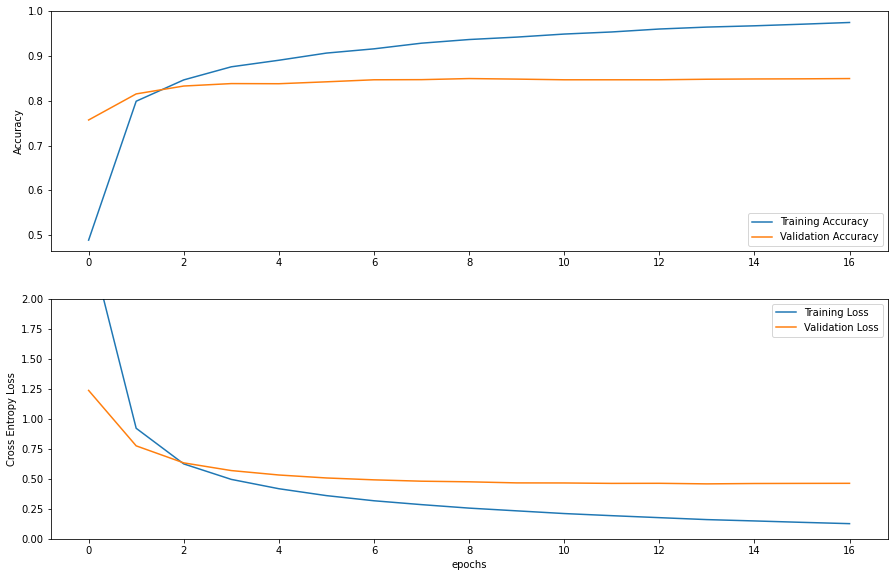

In [12]:
res = hist.history

acc = res['accuracy']
val_acc = res['val_accuracy']

loss = res['loss']
val_loss = res['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epochs')
plt.ylim([0,2.0])
plt.show()

# Unfreeze trainable weights from base model and fine tune

In [63]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [64]:
optimizer = keras.optimizers.Nadam(learning_rate = 1e-5)
loss = keras.losses.CategoricalCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])

# Start training starting from previous training

In [65]:
hist_fine = model.fit(
    ds_train,
    epochs = 100,
    initial_epoch = hist.epoch[-1],
    validation_data = ds_val,
    callbacks = [early_stopping]
)

Epoch 17/100
1029/1029 [==============================] - 130s 120ms/step - loss: 0.1385 - accuracy: 0.9575 - val_loss: 0.5645 - val_accuracy: 0.8364
Epoch 18/100
1029/1029 [==============================] - 111s 108ms/step - loss: 0.0877 - accuracy: 0.9768 - val_loss: 0.6187 - val_accuracy: 0.8321
Epoch 19/100
1029/1029 [==============================] - 111s 108ms/step - loss: 0.0636 - accuracy: 0.9852 - val_loss: 0.6192 - val_accuracy: 0.8361
Epoch 20/100
1029/1029 [==============================] - 111s 108ms/step - loss: 0.0515 - accuracy: 0.9879 - val_loss: 0.6390 - val_accuracy: 0.8303
Epoch 00020: early stopping


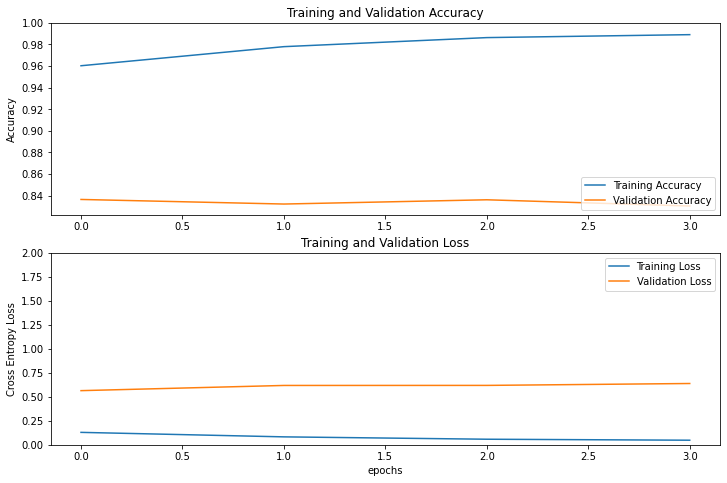

In [66]:
res_fine = hist_fine.history

acc = res_fine['accuracy']
val_acc = res_fine['val_accuracy']

loss = res_fine['loss']
val_loss = res_fine['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epochs')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.show()

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ruffl\AppData\Local\Temp\tmp2n6s1hsy\assets


In [29]:
with open('mv2_20k_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Test loss and accuracy for test set

In [13]:
loss, accuracy = model.evaluate(test_dataset)

51/51 [==============================] - 5s 84ms/step - loss: 0.4524 - accuracy: 0.8517


# Get confusion matrix

In [15]:
pred = []
true = []

for img_batch, label_batch in test_dataset:
    true.append(label_batch)
    preds = model.predict(img_batch)
    pred.append(np.argmax(preds, axis = -1))
    
correct_labels = tf.concat([item for item in true], axis = 0)
correct_labels = tf.math.argmax(correct_labels, axis = 1)
pred_labels = tf.concat([item for item in pred], axis = 0)

cf = cf(correct_labels, pred_labels)

In [34]:
cf

array([[ 8,  0,  0, ...,  0,  0,  0],
       [ 0,  4,  0, ...,  0,  0,  0],
       [ 0,  0,  4, ...,  0,  0,  1],
       ...,
       [ 0,  0,  0, ...,  5,  0,  0],
       [ 0,  0,  0, ...,  0, 12,  0],
       [ 0,  0,  0, ...,  0,  0,  5]], dtype=int64)

# Calculate fp, fn, tp, tn, accuracy, sensitivity, specificity, precision

In [32]:
fp = cf.sum(axis = 0) - np.diag(cf)
fn = cf.sum(axis = 1) - np.diag(cf)
tp = np.diag(cf)
tn = cf.sum() - (fp + fn + tp)
acc = (tp + tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp + fn)
specificity = tn/(tn + fp)
precision = tp/(tp + fp)
("FALSE POSITIVES", fp,"FALSE NEGATIVES", fn,"TRUE POSITIVES", tp,"TRUE NEGATIVES", tn,"ACCURACY", acc,
 "SENSITIVITY", sensitivity,"SPECIFICITY", specificity,"PRECISION", precision)

<ipython-input-32-3fbde72f05e5>:8: RuntimeWarning: invalid value encountered in true_divide
  precision = tp/(tp + fp)


('FALSE POSITIVES',
 array([0, 0, 0, 2, 1, 0, 0, 3, 0, 4, 1, 0, 2, 0, 3, 1, 1, 0, 0, 0, 3, 3,
        1, 1, 3, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 1, 0, 1, 2, 0, 2,
        1, 0, 0, 3, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 3, 1, 0, 7, 5, 2,
        0, 0, 1, 2, 1, 2, 1, 1, 0, 0, 2, 1, 3, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 2, 1, 1, 1, 0, 0, 3, 2, 0, 1, 2, 3, 1, 1, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 3, 1, 0, 1, 1, 3, 3], dtype=int64),
 'FALSE NEGATIVES',
 array([0, 0, 2, 3, 2, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 3,
        1, 3, 5, 0, 2, 2, 1, 1, 5, 1, 0, 1, 2, 0, 4, 1, 0, 1, 2, 2, 0, 4,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 1, 2, 1,
        0, 0, 4, 4, 1, 1, 0, 2, 0, 0, 1, 1, 1, 2, 1, 0, 1, 2, 0, 2, 0, 1,
        0, 3, 0, 0, 0, 0, 2, 1, 0, 0, 4, 0, 0, 1, 3, 0, 2, 0, 0, 3, 0, 0,
        2, 1, 1, 0, 0, 1, 0, 1, 2, 1], dtype=int64),
 'TRUE POSITIVES',
 array([ 8,  4,  4,  4,  6,  4,  4,  3, 10,  7,  5,  7,  9,  5,  6,  1,  5,
         6,  3,  6,

# Plot images from test set with predicted labels

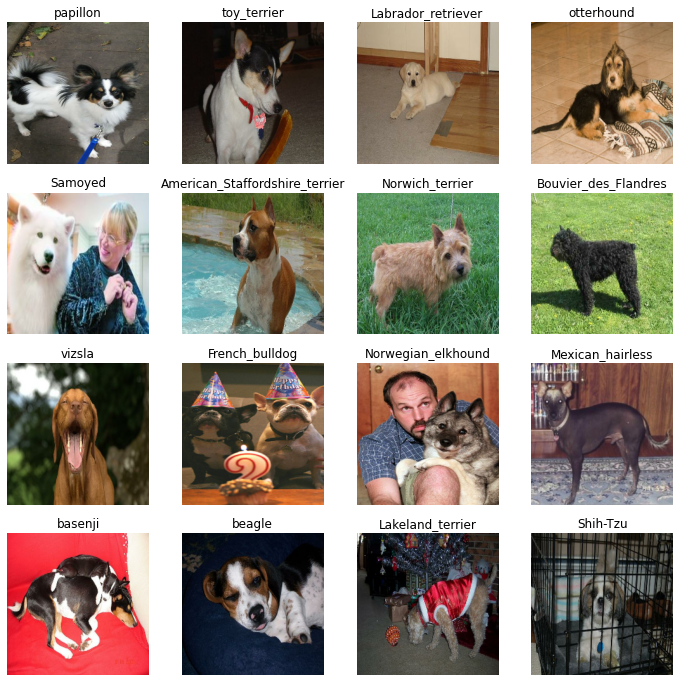

In [62]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

index = tf.math.argmax(predictions, axis = 1)

plt.figure(figsize=(12, 12))
for i in range(batch_size):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(labels[index[i]])
    plt.axis("off")